<a href="https://colab.research.google.com/github/ksdkamesh99/LowLightEnhancer/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/My Drive/LowLightEnhancement

/content/drive/My Drive/LowLightEnhancement


In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image

In [3]:
img_high=np.load("image_high.npy")

In [4]:
img_low=np.load("image_low.npy")

In [5]:
img_high.shape

(1485, 150, 150, 3)

## Illumination Mask Network

In [6]:
input_layer=tf.keras.layers.Input(shape=(150,150,3))

In [7]:
top_inp=input_layer
top=tf.keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(150,150,3),activation='relu')(top_inp)
top=tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(top)

In [8]:
bottom_inp=input_layer
bottom_resize=tf.keras.layers.Lambda( 
    lambda image: tf.compat.v1.image.resize_nearest_neighbor( 
        image, 
        (224, 224)
    )
)(bottom_inp)


In [9]:
bottom=tf.keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu')(bottom_resize)
bottom=tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)
bottom=tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)
bottom=tf.keras.layers.Lambda( 
    lambda image: tf.compat.v1.image.resize_nearest_neighbor( 
        image, 
        (146,146)
    )
)(bottom)

In [10]:
bottom.get_shape()

TensorShape([None, 146, 146, 64])

In [11]:
top.get_shape()

TensorShape([None, 146, 146, 64])

In [12]:
merged=tf.keras.layers.concatenate([top,bottom],axis=-1)

In [13]:
merged=tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(merged)
merged=tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu')(merged)
merged=tf.keras.layers.Conv2D(3,kernel_size=(3,3),activation='relu')(merged)

In [14]:
merged.get_shape()

TensorShape([None, 140, 140, 3])

In [15]:
model_illumination_mask=tf.keras.models.Model(inputs=input_layer,outputs=merged)

In [16]:
model_illumination_mask.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 222, 222, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 220, 220, 64) 36928       conv2d_2[0][0]                   
_______________________________________________________________________________________

# Illumination Map 

In [17]:
merged=tf.keras.layers.Lambda( 
    lambda image: tf.compat.v1.image.resize_nearest_neighbor( 
        image,
        (150,150)
    )
)(merged)

In [18]:
merged.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'lambda_2/ResizeNearestNeighbor:0' shape=(None, 150, 150, 3) dtype=float32>>

In [19]:
merged=tf.keras.layers.Concatenate()([input_layer,merged])

In [20]:
merged

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 150, 150, 6) dtype=float32>

In [21]:
def ieb(input_feature):
  ieb1=tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(input_feature)
  ieb1=tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(ieb1)
  max_pool=tf.keras.layers.GlobalMaxPooling2D()(ieb1)
  avg_pool=tf.keras.layers.GlobalAveragePooling2D()(ieb1)
  dense1=tf.keras.layers.Dense(8,activation='relu',kernel_initializer='he_normal')
  dense2=tf.keras.layers.Dense(64,activation='sigmoid',kernel_initializer='he_normal')
  max_pool=dense1(max_pool)
  max_pool=dense2(max_pool)
  avg_pool=dense1(avg_pool)
  avg_pool=dense2(avg_pool)
  max_pool=tf.keras.layers.Lambda(
    lambda image: tf.expand_dims(tf.expand_dims(image,axis=1),axis=1))(max_pool)
  avg_pool=tf.keras.layers.Lambda(
    lambda image: tf.expand_dims(tf.expand_dims(image,axis=1),axis=1))(avg_pool)
  channel=tf.keras.layers.Add()([max_pool,avg_pool])
  ieb1=tf.keras.layers.Multiply()([ieb1,channel])
  max_pool_s=tf.keras.layers.Lambda(
    lambda x: tf.keras.backend.max(x,axis=3,keepdims=True))(ieb1)
  avg_pool_s=tf.keras.layers.Lambda(
    lambda x: tf.keras.backend.mean(x,axis=3,keepdims=True))(ieb1)
  concat_slayers=tf.keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s])
  spacial=tf.keras.layers.Conv2D(1,7,activation='sigmoid')(concat_slayers)
  spacial=tf.keras.layers.Lambda( 
    lambda image: tf.compat.v1.image.resize_nearest_neighbor( 
        image, 
        (146,146)
    ))(spacial)
  ieb1=tf.keras.layers.Multiply()([ieb1,spacial])
  ieb1=tf.keras.layers.BatchNormalization()(ieb1)
  ieb1=tf.keras.layers.Activation('relu')(ieb1)
  ieb1=tf.keras.layers.Lambda(
    lambda image: tf.compat.v1.image.resize_nearest_neighbor(image,(150,150)))(ieb1)
  return ieb1


  



In [22]:
ieb_1=ieb(merged)

In [23]:
ieb_2=ieb(ieb_1)

In [24]:
ieb_3=ieb(ieb_2)

In [25]:
ieb_4=ieb(ieb_3)

In [26]:
ieb_5=ieb(ieb_4)

In [27]:
added_ieb=tf.keras.layers.Add()([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

In [28]:
impnet=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(added_ieb)

In [29]:
impnet=tf.keras.layers.Conv2D(16,(3,3),activation='relu')(impnet)

In [30]:
impnet=tf.keras.layers.Conv2D(3,(3,3),activation='relu')(impnet)

In [31]:
impnet=tf.keras.layers.Lambda(
    lambda image: tf.compat.v1.image.resize_nearest_neighbor(image,
                                                             (150,150))
)(impnet)

In [32]:
impnet

<tf.Tensor 'lambda_33/ResizeNearestNeighbor:0' shape=(None, 150, 150, 3) dtype=float32>

# S/L Block 

In [33]:
impnet=tf.keras.layers.Lambda(
    lambda x: x+tf.keras.backend.constant(0.01)
)(impnet)

In [34]:
s_l=tf.keras.layers.Lambda(
    lambda input:(input[0])/(input[1])
)([input_layer,impnet])

In [35]:
s_l

<tf.Tensor 'lambda_35/truediv:0' shape=(None, 150, 150, 3) dtype=float32>

# Correction Network

In [36]:
def correction_network(input_feature):
  conv1=tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(input_feature)
  conv2=tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(conv1)
  conv3=tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(conv2)
  conv4=tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(conv3)
  conv5=tf.keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='relu')(conv4)
  conv5=tf.keras.layers.Lambda(
      lambda image:tf.compat.v1.image.resize_nearest_neighbor(
          image,size=(150,150)
      )
  )(conv5)
  return conv5

In [37]:
final_output=correction_network(s_l)

# Custom Loss Function

In [104]:
import loss as l

In [105]:
def custom_loss_wrapper(input_tensor):
  def custom_loss(y_true,y_pred):
    lm_loss=l.light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
    e_loss=l.enhancement_loss(y_true,y_pred)
    c_loss=l.color_loss(y_true,y_pred)
    s_loss=l.denoising_loss(y_true,y_pred)
    total_loss=(10*lm_loss)+(1*e_loss)+(0.2*s_loss)+(1*c_loss)
    return total_loss
  return custom_loss

# Model

In [106]:
model=tf.keras.models.Model(inputs=input_layer,outputs=final_output)

In [107]:
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 222, 222, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 220, 220, 64) 36928       conv2d_2[0][0]                   
______________________________________________________________________________________

# Plot a DL Model

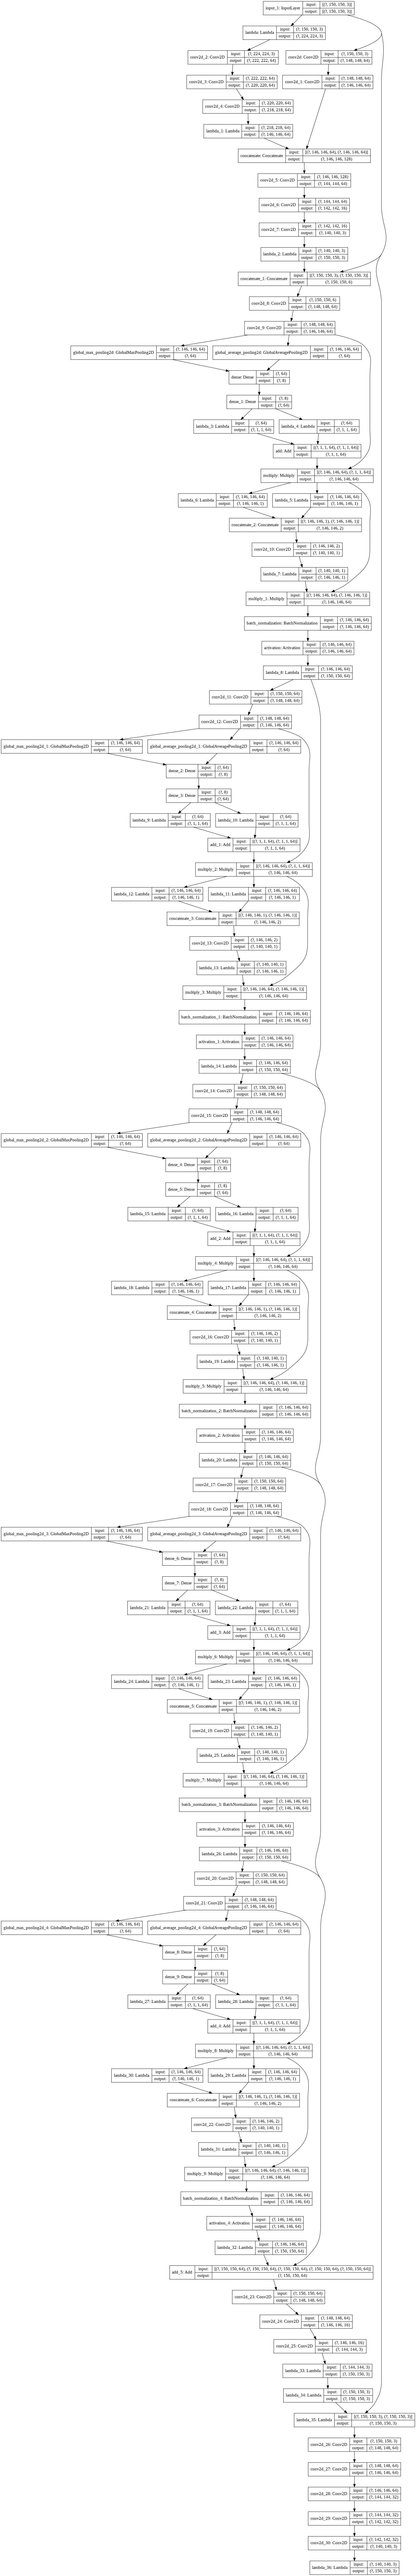

In [108]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Model Compile

In [109]:
model.compile(optimizer='Adam',loss=custom_loss_wrapper(input_layer),metrics=[tf.keras.metrics.MSE])

In [110]:
img_high.shape

(1485, 150, 150, 3)